In [1]:
cd ~/projects/Okapi/tests/transfers/okapi-moose/pin_coupling/

/Users/lindad/projects/Okapi/tests/transfers/okapi-moose/pin_coupling


In [2]:
import openmc

import matplotlib.pyplot as plt
%matplotlib inline

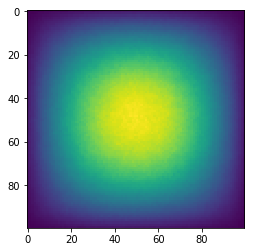

In [3]:
with openmc.StatePoint('statepoint.50.h5') as sp:
    mesh_tally = sp.get_tally(id=2)

    mesh_fission = mesh_tally.get_slice(scores=['kappa-fission'])
    mesh_fission.mean.shape = (100,100)

    plt.imshow(mesh_fission.mean)

    zernike_tally = sp.get_tally(id=1)

In [4]:
from series.Zernike import Zernike

max_order = 10
zernike_list = [Zernike(order, 0, 0, 60) for order in range(max_order + 1)]

In [5]:
zernike_tally.mean.shape = (zernike_tally.mean.size)

for order in range(max_order + 1):
    n = (order + 1) * (order + 2) // 2
    zernike_list[order].coefficients = zernike_tally.mean[:n]

In [6]:
import numpy as np

r = np.linspace(0, 60, 100)
z_evals = [np.zeros((r.size)) for zernike in zernike_list]

for r_index, radius in enumerate(r):
    for z_index, zernike in enumerate(zernike_list):
        z_evals[z_index][r_index] = zernike(radius, 0, normalization="orthonormal")

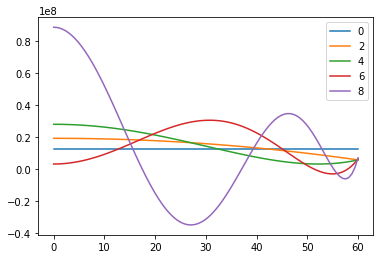

In [9]:
for order, z in enumerate(z_evals):
    if order % 2 == 0 and order <= 8:
        plt.plot(r, z, label=str(order))
plt.legend()

### Below, note the oscillations introduced by a high order Zernike

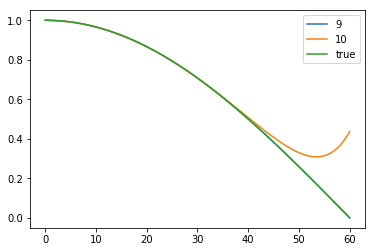

In [54]:
from math import cos, pi

def sinusoid(r, phi, R=60):
    return cos(pi * r / (2 * R))

for zernike in zernike_list:
    zernike.generateCoefficients(sinusoid, num_rintervals=100, num_aintervals=10, normalization="standard")

for r_index, radius in enumerate(r):
    for z_index, zernike in enumerate(zernike_list):
        z_evals[z_index][r_index] = zernike(radius, 0, normalization="orthonormal")

for order, z in enumerate(z_evals):
    if order == 10 or order == 9:
        plt.plot(r, z, label=str(order))
true = np.zeros((r.size))
for index, radius in enumerate(r):
    true[index] = sinusoid(radius, 0)
plt.plot(r, true, label='true')
plt.legend()

### These oscillations can be removed by increasing the accuracy of the integration performed for coefficient generation

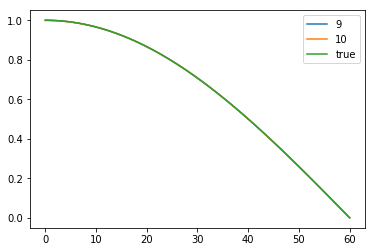

In [55]:
from math import cos, pi

def sinusoid(r, phi, R=60):
    return cos(pi * r / (2 * R))

for zernike in zernike_list:
    zernike.generateCoefficients(sinusoid, num_rintervals=100, num_aintervals=20, normalization="standard")

for r_index, radius in enumerate(r):
    for z_index, zernike in enumerate(zernike_list):
        z_evals[z_index][r_index] = zernike(radius, 0, normalization="orthonormal")

for order, z in enumerate(z_evals):
    if order == 10 or order == 9:
        plt.plot(r, z, label=str(order))
true = np.zeros((r.size))
for index, radius in enumerate(r):
    true[index] = sinusoid(radius, 0)
plt.plot(r, true, label='true')
plt.legend()

In [14]:
def linear(r, phi):
    return r

### The same oscillatory behavior can be seen with a linear function

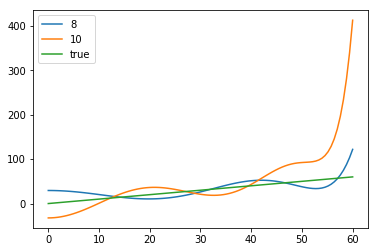

In [74]:
for index, zernike in enumerate(zernike_list):
    if index >= 6:
        zernike.generateCoefficients(linear, num_rintervals=10, num_aintervals=10,
                                 normalization="standard")
    

for r_index, radius in enumerate(r):
    for z_index, zernike in enumerate(zernike_list):
        if z_index >= 6:
            z_evals[z_index][r_index] = zernike(radius, 0, normalization="orthonormal")

for order, z in enumerate(z_evals):
    if order % 2 == 0 and order > 6:
        plt.plot(r, z, label=str(order))
plt.plot(r, r, label='true')
plt.legend()

### And again can be removed by increasing the accuracy of the integration

In [ ]:
for index, zernike in enumerate(zernike_list):
    if index >= 6:
        zernike.generateCoefficients(linear, num_rintervals=200, num_aintervals=200,
                                 normalization="standard")
    

for r_index, radius in enumerate(r):
    for z_index, zernike in enumerate(zernike_list):
        if z_index >= 6:
            z_evals[z_index][r_index] = zernike(radius, 0, normalization="orthonormal")

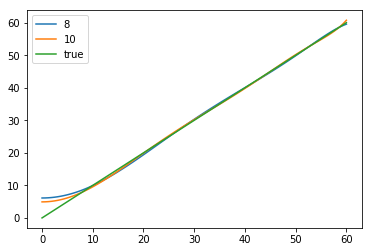

In [71]:
for order, z in enumerate(z_evals):
    if order % 2 == 0 and order > 6:
        plt.plot(r, z, label=str(order))
plt.plot(r, r, label='true')
plt.legend()

### Tool for checking Zernike polynomial generation

In [36]:
import sympy as sp

def coeffs(m, n):
    clist = []
    clist.append(2 * (n - 1) * n * (n - 2))
    clist.append((n - 1) * (-m**2 - n * (n - 2)))
    clist.append(-n * (n + m - 2) * (n - m - 2) / 2)
    return [item / ((n + m) * (n - m) * (n - 2)) * 2 for item in clist]

rho = sp.symbols('rho')

def R(m, n):
    if m == n:
        return rho**n
    elif n == m + 2:
        return ((m + 2) * rho**2 - (m + 1)) * rho**m
    else:
        coeff1, coeff2, coeff3 = coeffs(m, n)
        return (coeff1 * rho**2 + coeff2) * R(m, n-2) + coeff3 * R(m, n-4)

Using the code above, we determined that the radial Zernike polynomials in the MOOSE FET module are accurate!